[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/danpele/Time-Series-Analysis/blob/main/EN/Course_Notebooks/chapter1_lecture_notebook.ipynb)

---

# Chapter 1: Introduction to Time Series Analysis

**Course:** Time Series Analysis and Forecasting  
**Program:** Bachelor program, Faculty of Cybernetics, Statistics and Economic Informatics, Bucharest University of Economic Studies, Romania  
**Academic Year:** 2025-2026

---

## Learning Objectives

By the end of this notebook, you will be able to:
1. Define time series and distinguish from other data types
2. Decompose time series into trend, seasonal, and residual components
3. Apply exponential smoothing methods (SES, Holt, Holt-Winters)
4. Evaluate forecasts using MAE, RMSE, MAPE
5. Understand stationarity and test for it (ADF, KPSS)
6. Compute and interpret ACF and PACF

## Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Time series specific
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Plotting style - clean, professional
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.facecolor'] = 'none'  # Transparent background
plt.rcParams['figure.facecolor'] = 'none'  # Transparent figure
plt.rcParams['savefig.facecolor'] = 'none'
plt.rcParams['savefig.transparent'] = True
plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.grid'] = False  # No grid
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Colors (IDA color scheme)
COLORS = {
    'blue': '#1A3A6E',
    'red': '#DC3545',
    'green': '#2E7D32',
    'orange': '#E67E22',
    'gray': '#666666'
}

print("All libraries loaded successfully!")

All libraries loaded successfully!


## 1. What is a Time Series?

A **time series** is a sequence of observations indexed by time:

$$\{X_t : t \in \mathcal{T}\}$$

### Key Characteristics:
- **Ordered**: Observations have a natural temporal ordering
- **Dependent**: Consecutive observations are typically correlated
- **Discrete or Continuous**: Time index can be discrete or continuous

In [2]:
# Download real financial data
print("Downloading S&P 500 data...")
sp500 = yf.download('^GSPC', start='2020-01-01', end='2025-01-01', progress=False)
# Flatten multi-level columns (newer yfinance returns MultiIndex)
if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = sp500.columns.droplevel(1)
print(f"Downloaded {len(sp500)} observations")

# Display first few rows
sp500.head()

Downloaded 1258 observations


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,3257.850098,3258.139893,3235.530029,3244.669922,3459930000
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000


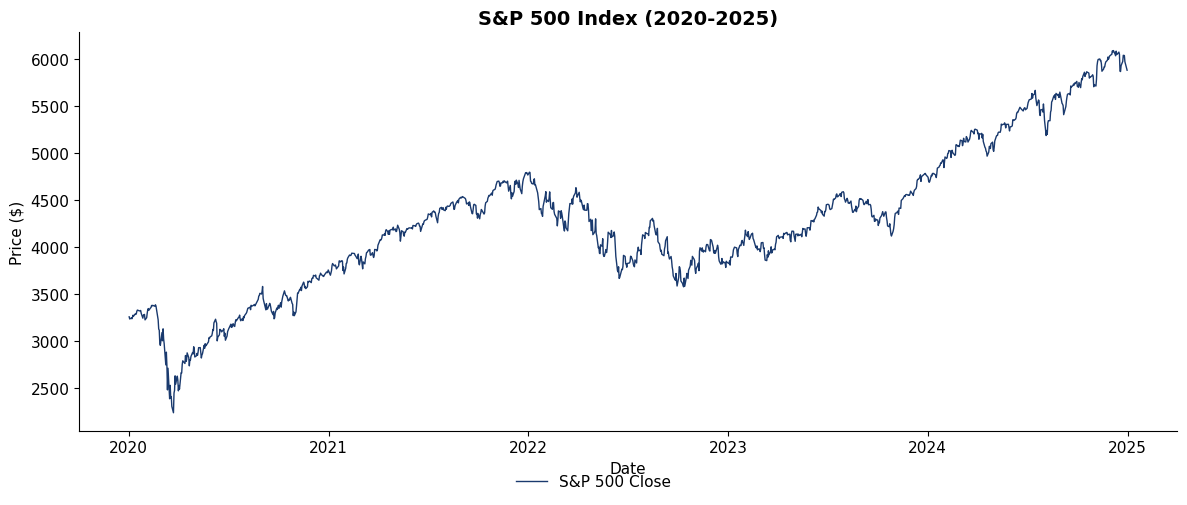

In [3]:
# Plot the time series
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(sp500.index, sp500['Close'], color=COLORS['blue'], linewidth=1, label='S&P 500 Close')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('S&P 500 Index (2020-2025)', fontweight='bold', fontsize=14)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [4]:
print(f"\nBasic Statistics:")
print(f"Mean: ${sp500['Close'].mean():.2f}")
print(f"Std Dev: ${sp500['Close'].std():.2f}")
print(f"Min: ${sp500['Close'].min():.2f}")
print(f"Max: ${sp500['Close'].max():.2f}")


Basic Statistics:
Mean: $4259.61
Std Dev: $767.45
Min: $2237.40
Max: $6090.27


### Types of Data: Comparison

| Data Type | Units (N) | Time (T) | Example |
|-----------|-----------|----------|----------|
| Cross-sectional | Many | 1 | Survey of 1000 households |
| Time series | 1 | Many | Daily S&P 500 prices |
| Panel | Many | Many | GDP of 50 countries, 20 years |

## 2. Time Series Decomposition

### Decomposition Models

**Additive Model:** $X_t = T_t + S_t + \varepsilon_t$
- Use when seasonal fluctuations are **constant** over time

**Multiplicative Model:** $X_t = T_t \times S_t \times \varepsilon_t$
- Use when seasonal fluctuations **grow** with the level

In [5]:
# Load airline passengers data (classic example with trend and seasonality)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
airline = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
airline.columns = ['Passengers']

print(f"Airline Passengers Data: {len(airline)} observations")
print(f"Period: {airline.index[0].strftime('%Y-%m')} to {airline.index[-1].strftime('%Y-%m')}")
airline.head()

Airline Passengers Data: 144 observations
Period: 1949-01 to 1960-12


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


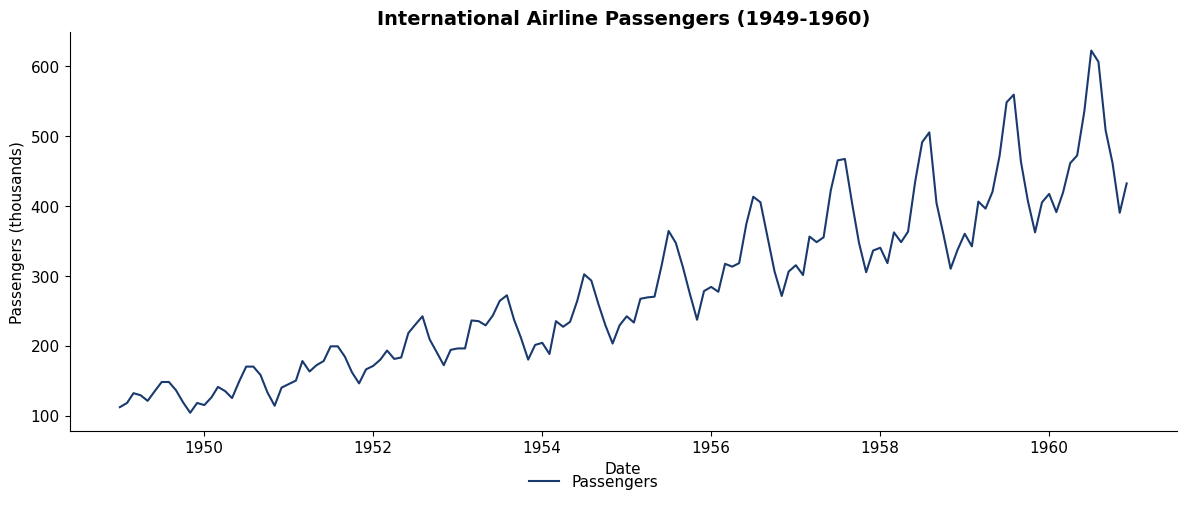

In [6]:
# Plot airline data
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(airline.index, airline['Passengers'], color=COLORS['blue'], linewidth=1.5, label='Passengers')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers (thousands)')
ax.set_title('International Airline Passengers (1949-1960)', fontweight='bold', fontsize=14)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [7]:
print("\nObservations:")
print("- Clear upward TREND")
print("- Regular SEASONAL pattern (peaks in summer)")
print("- Seasonal amplitude INCREASES with level -> Multiplicative!")


Observations:
- Clear upward TREND
- Regular SEASONAL pattern (peaks in summer)
- Seasonal amplitude INCREASES with level -> Multiplicative!


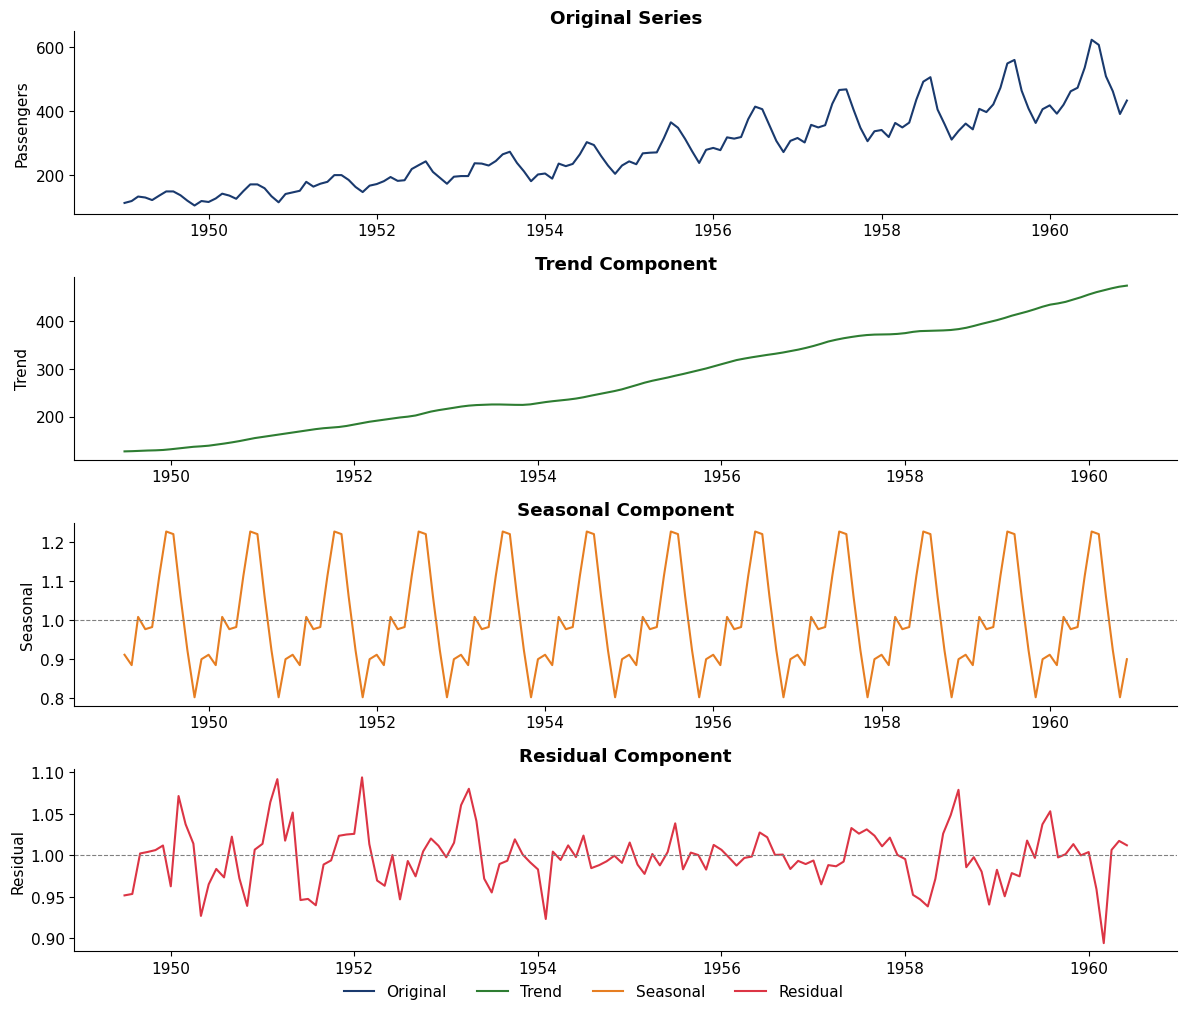

In [8]:
# Classical Decomposition - Multiplicative
decomposition = seasonal_decompose(airline['Passengers'], model='multiplicative', period=12)

fig, axes = plt.subplots(4, 1, figsize=(12, 10))

axes[0].plot(airline.index, airline['Passengers'], color=COLORS['blue'], label='Original')
axes[0].set_title('Original Series', fontweight='bold')
axes[0].set_ylabel('Passengers')

axes[1].plot(airline.index, decomposition.trend, color=COLORS['green'], label='Trend')
axes[1].set_title('Trend Component', fontweight='bold')
axes[1].set_ylabel('Trend')

axes[2].plot(airline.index, decomposition.seasonal, color=COLORS['orange'], label='Seasonal')
axes[2].set_title('Seasonal Component', fontweight='bold')
axes[2].set_ylabel('Seasonal')
axes[2].axhline(y=1, color='gray', linestyle='--', linewidth=0.8)

axes[3].plot(airline.index, decomposition.resid, color=COLORS['red'], label='Residual')
axes[3].set_title('Residual Component', fontweight='bold')
axes[3].set_ylabel('Residual')
axes[3].axhline(y=1, color='gray', linestyle='--', linewidth=0.8)

# Collect handles and labels from all axes
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.08)
plt.tight_layout()
plt.show()

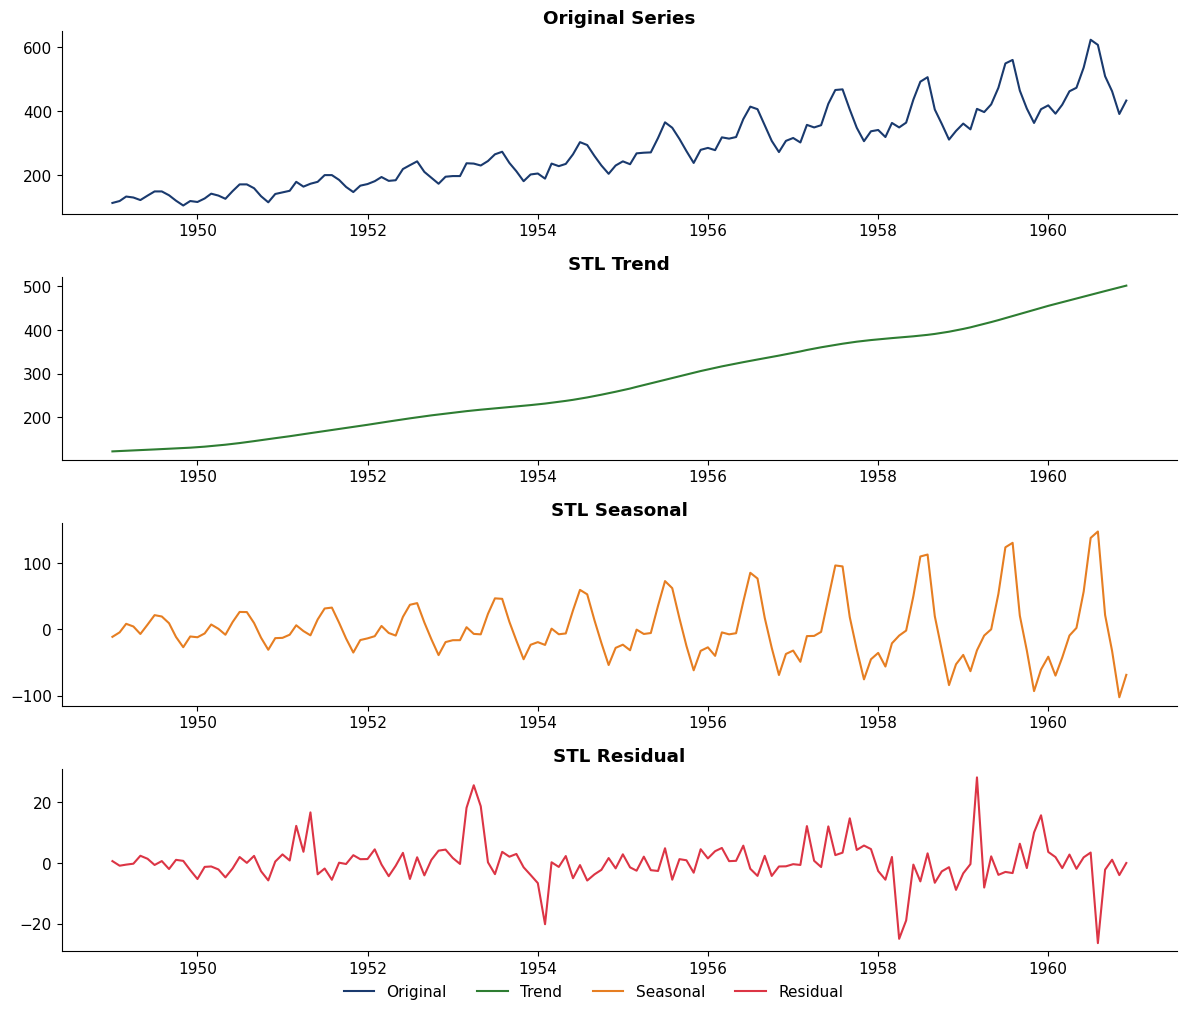

In [9]:
# STL Decomposition (more robust)
stl = STL(airline['Passengers'], period=12, robust=True)
stl_result = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(12, 10))

axes[0].plot(airline.index, airline['Passengers'], color=COLORS['blue'], label='Original')
axes[0].set_title('Original Series', fontweight='bold')

axes[1].plot(airline.index, stl_result.trend, color=COLORS['green'], label='Trend')
axes[1].set_title('STL Trend', fontweight='bold')

axes[2].plot(airline.index, stl_result.seasonal, color=COLORS['orange'], label='Seasonal')
axes[2].set_title('STL Seasonal', fontweight='bold')

axes[3].plot(airline.index, stl_result.resid, color=COLORS['red'], label='Residual')
axes[3].set_title('STL Residual', fontweight='bold')

# Collect handles and labels from all axes
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.08)
plt.tight_layout()
plt.show()

In [10]:
print("STL Decomposition is ADDITIVE: X = Trend + Seasonal + Residual")

STL Decomposition is ADDITIVE: X = Trend + Seasonal + Residual


### Seasonal Indices Interpretation

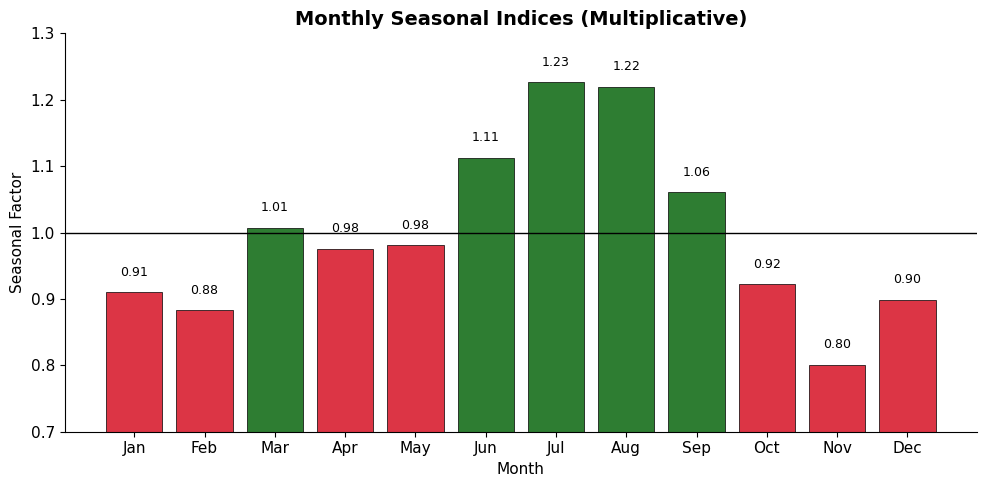

In [11]:
# Extract monthly seasonal factors
seasonal_factors = decomposition.seasonal[:12]

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(10, 5))
colors = [COLORS['red'] if s < 1 else COLORS['green'] for s in seasonal_factors]
bars = ax.bar(months, seasonal_factors, color=colors, edgecolor='black', linewidth=0.5)
ax.axhline(y=1, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Month')
ax.set_ylabel('Seasonal Factor')
ax.set_title('Monthly Seasonal Indices (Multiplicative)', fontweight='bold', fontsize=14)
ax.set_ylim(0.7, 1.3)

# Add value labels
for bar, val in zip(bars, seasonal_factors):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [12]:
print("\nInterpretation:")
print(f"- July factor = {seasonal_factors.iloc[6]:.2f} -> {(seasonal_factors.iloc[6]-1)*100:.0f}% above average")
print(f"- November factor = {seasonal_factors.iloc[10]:.2f} -> {(1-seasonal_factors.iloc[10])*100:.0f}% below average")


Interpretation:
- July factor = 1.23 -> 23% above average
- November factor = 0.80 -> 20% below average


## 3. Exponential Smoothing Methods

### Simple Exponential Smoothing (SES)

$$\hat{X}_{t+1|t} = \alpha X_t + (1-\alpha)\hat{X}_{t|t-1}$$

where $\alpha \in (0,1)$ is the smoothing parameter.

- **Large α**: Responsive to recent changes
- **Small α**: Smoother, more stable forecasts

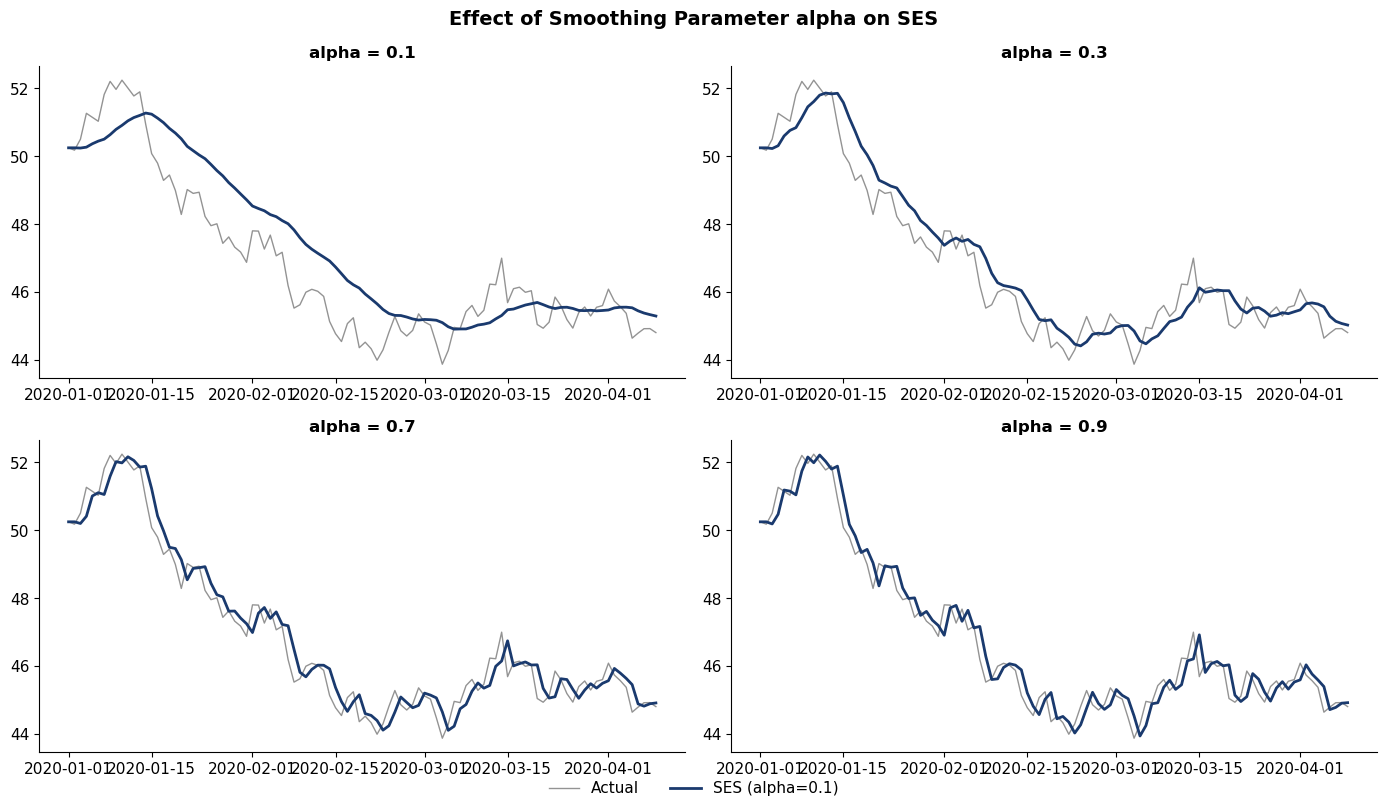

In [13]:
# Create synthetic data without trend/seasonality for SES demo
np.random.seed(42)
n = 100
synthetic = pd.Series(50 + np.cumsum(np.random.randn(n) * 0.5), 
                      index=pd.date_range('2020-01-01', periods=n, freq='D'))

# Fit SES with different alpha values
alphas = [0.1, 0.3, 0.7, 0.9]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, alpha in enumerate(alphas):
    model = SimpleExpSmoothing(synthetic).fit(smoothing_level=alpha, optimized=False)
    fitted = model.fittedvalues
    
    axes[i].plot(synthetic.index, synthetic, color=COLORS['gray'], 
                 linewidth=1, alpha=0.7, label='Actual')
    axes[i].plot(fitted.index, fitted, color=COLORS['blue'], 
                 linewidth=2, label=f'SES (alpha={alpha})')
    axes[i].set_title(f'alpha = {alpha}', fontweight='bold', fontsize=12)

# Collect handles and labels from the first subplot (same for all)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))
plt.suptitle('Effect of Smoothing Parameter alpha on SES', fontweight='bold', fontsize=14)
plt.subplots_adjust(bottom=0.1)
plt.tight_layout()
plt.show()

In [14]:
print("Observation: Higher alpha -> more reactive to changes, Lower alpha -> smoother")

Observation: Higher alpha -> more reactive to changes, Lower alpha -> smoother


### Holt's Linear Trend Method

**Level:** $\ell_t = \alpha X_t + (1-\alpha)(\ell_{t-1} + b_{t-1})$

**Trend:** $b_t = \beta^*(\ell_t - \ell_{t-1}) + (1-\beta^*)b_{t-1}$

**Forecast:** $\hat{X}_{t+h|t} = \ell_t + h \cdot b_t$

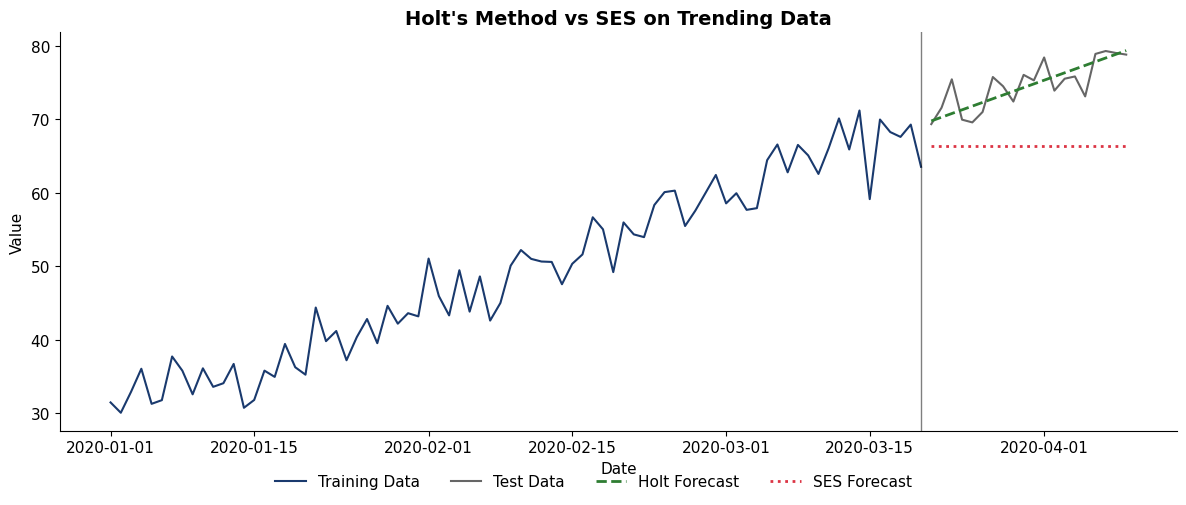

In [15]:
# Create data with trend
np.random.seed(42)
n = 100
trend_data = pd.Series(30 + 0.5 * np.arange(n) + np.random.randn(n) * 3,
                       index=pd.date_range('2020-01-01', periods=n, freq='D'))

# Split into train/test
train_size = 80
train = trend_data[:train_size]
test = trend_data[train_size:]

# Fit Holt's method
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
holt_forecast = holt_model.forecast(len(test))

# Also fit SES for comparison
ses_model = SimpleExpSmoothing(train).fit()
ses_forecast = ses_model.forecast(len(test))

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(train.index, train, color=COLORS['blue'], linewidth=1.5, label='Training Data')
ax.plot(test.index, test, color=COLORS['gray'], linewidth=1.5, label='Test Data')
ax.plot(test.index, holt_forecast, color=COLORS['green'], linewidth=2, 
        linestyle='--', label='Holt Forecast')
ax.plot(test.index, ses_forecast, color=COLORS['red'], linewidth=2, 
        linestyle=':', label='SES Forecast')
ax.axvline(x=train.index[-1], color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title("Holt's Method vs SES on Trending Data", fontweight='bold', fontsize=14)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [16]:
# Calculate errors
holt_rmse = np.sqrt(mean_squared_error(test, holt_forecast))
ses_rmse = np.sqrt(mean_squared_error(test, ses_forecast))
print(f"\nHolt RMSE: {holt_rmse:.2f}")
print(f"SES RMSE: {ses_rmse:.2f}")
print(f"\nHolt captures the trend, SES does not!")


Holt RMSE: 2.03
SES RMSE: 8.92

Holt captures the trend, SES does not!


### Holt-Winters Seasonal Method

Extends Holt's method to include **seasonality** with three equations:

- **Level:** $\ell_t = \alpha(X_t - S_{t-s}) + (1-\alpha)(\ell_{t-1} + b_{t-1})$
- **Trend:** $b_t = \beta^*(\ell_t - \ell_{t-1}) + (1-\beta^*)b_{t-1}$  
- **Seasonal:** $S_t = \gamma(X_t - \ell_t) + (1-\gamma)S_{t-s}$

In [17]:
# Use airline data with train/test split
train_airline = airline[:'1958']
test_airline = airline['1959':]

print(f"Training: {len(train_airline)} observations ({train_airline.index[0].strftime('%Y-%m')} to {train_airline.index[-1].strftime('%Y-%m')})")
print(f"Testing: {len(test_airline)} observations ({test_airline.index[0].strftime('%Y-%m')} to {test_airline.index[-1].strftime('%Y-%m')})")

Training: 120 observations (1949-01 to 1958-12)
Testing: 24 observations (1959-01 to 1960-12)


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


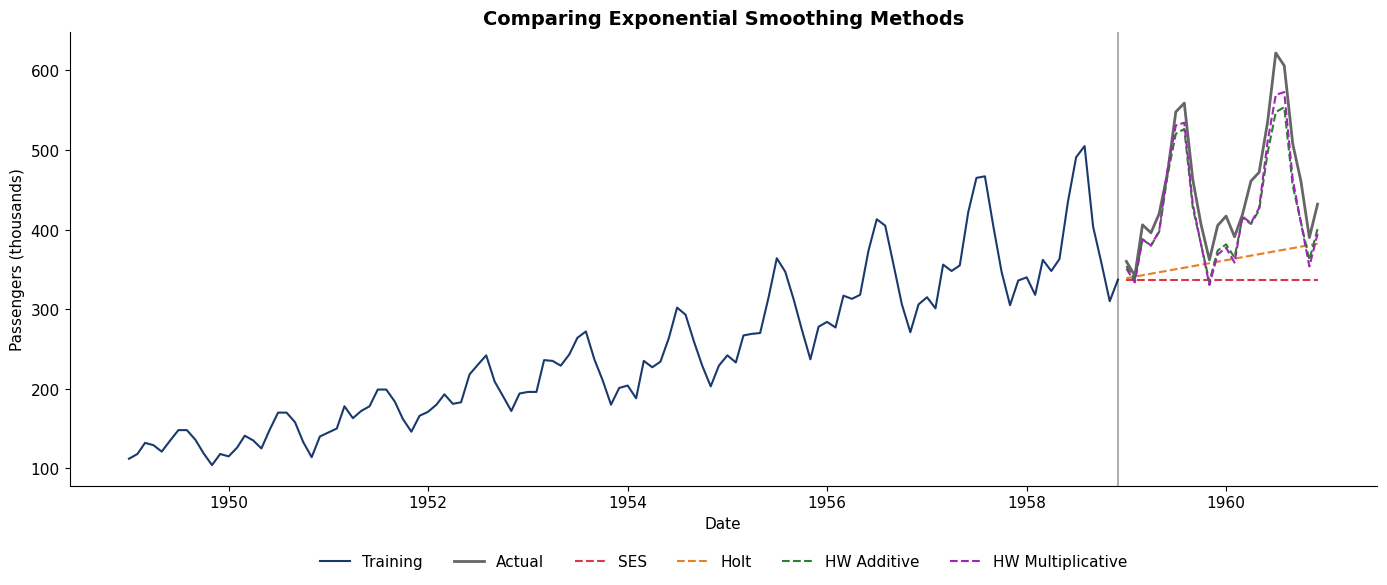

In [18]:
# Fit different methods
ses = SimpleExpSmoothing(train_airline['Passengers']).fit()
holt = ExponentialSmoothing(train_airline['Passengers'], trend='add', seasonal=None).fit()
hw_add = ExponentialSmoothing(train_airline['Passengers'], trend='add', 
                               seasonal='add', seasonal_periods=12).fit()
hw_mul = ExponentialSmoothing(train_airline['Passengers'], trend='add', 
                               seasonal='mul', seasonal_periods=12).fit()

# Generate forecasts
h = len(test_airline)
forecasts = {
    'SES': ses.forecast(h),
    'Holt': holt.forecast(h),
    'HW Additive': hw_add.forecast(h),
    'HW Multiplicative': hw_mul.forecast(h)
}

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(train_airline.index, train_airline['Passengers'], color=COLORS['blue'], 
        linewidth=1.5, label='Training')
ax.plot(test_airline.index, test_airline['Passengers'], color=COLORS['gray'], 
        linewidth=2, label='Actual')

colors_list = [COLORS['red'], COLORS['orange'], COLORS['green'], '#9C27B0']
for (name, fc), color in zip(forecasts.items(), colors_list):
    ax.plot(test_airline.index, fc, linewidth=1.5, linestyle='--', 
            color=color, label=name)

ax.axvline(x=train_airline.index[-1], color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Passengers (thousands)')
ax.set_title('Comparing Exponential Smoothing Methods', fontweight='bold', fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, frameon=False)
plt.tight_layout()
plt.show()

In [19]:
# Calculate error metrics
def mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

print("Forecast Accuracy Comparison:")
print("=" * 50)
print(f"{'Method':<20} {'RMSE':>10} {'MAE':>10} {'MAPE':>10}")
print("-" * 50)

actual = test_airline['Passengers'].values
for name, fc in forecasts.items():
    rmse = np.sqrt(mean_squared_error(actual, fc))
    mae = mean_absolute_error(actual, fc)
    mape_val = mape(actual, fc)
    print(f"{name:<20} {rmse:>10.2f} {mae:>10.2f} {mape_val:>9.2f}%")

print("\nConclusion: Holt-Winters Multiplicative performs best for seasonal data!")

Forecast Accuracy Comparison:
Method                     RMSE        MAE       MAPE
--------------------------------------------------
SES                      137.33     115.25     23.58%
Holt                     115.70      91.62     18.41%
HW Additive               35.76      31.08      6.64%
HW Multiplicative         32.49      28.98      6.39%

Conclusion: Holt-Winters Multiplicative performs best for seasonal data!


## 4. Forecast Evaluation

### Error Metrics

**Scale-Dependent:**
- MAE = $\frac{1}{n}\sum|e_t|$
- RMSE = $\sqrt{\frac{1}{n}\sum e_t^2}$

**Scale-Independent:**
- MAPE = $\frac{100}{n}\sum\left|\frac{e_t}{X_t}\right|$

### Train / Validation / Test Split

| Set | Purpose | Usage |
|-----|---------|-------|
| **Train** | Fit model parameters | 60-80% of data |
| **Validation** | Tune hyperparameters, compare models | 10-20% |
| **Test** | Final evaluation only | 10-20% |

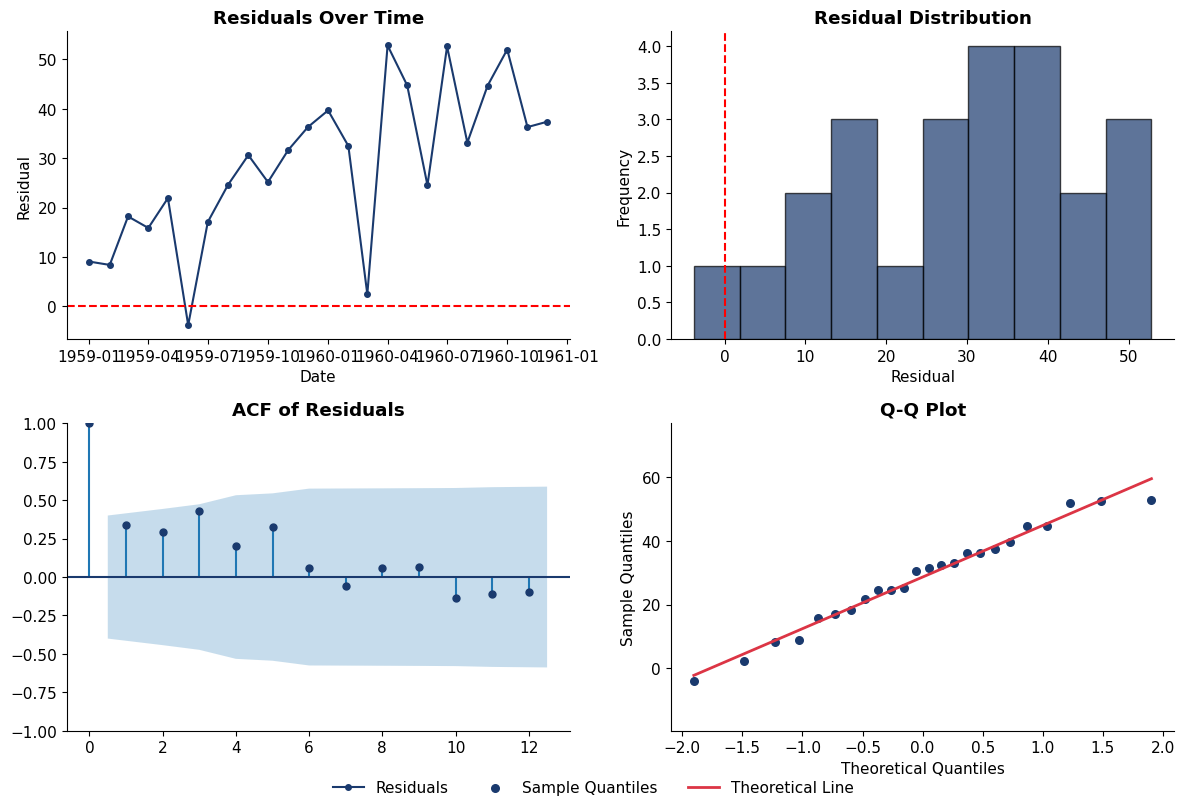

In [20]:
# Residual diagnostics for the best model
residuals = test_airline['Passengers'].values - forecasts['HW Multiplicative'].values

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residuals over time
axes[0, 0].plot(test_airline.index, residuals, color=COLORS['blue'], marker='o', markersize=4, label='Residuals')
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual')

# Histogram
axes[0, 1].hist(residuals, bins=10, color=COLORS['blue'], edgecolor='black', alpha=0.7, label='Residuals')
axes[0, 1].axvline(x=0, color='red', linestyle='--')
axes[0, 1].set_title('Residual Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')

# ACF of residuals
plot_acf(residuals, ax=axes[1, 0], lags=12, color=COLORS['blue'])
axes[1, 0].set_title('ACF of Residuals', fontweight='bold')

# Q-Q plot with equal axes
from scipy import stats
(osm, osr), (slope, intercept, r) = stats.probplot(residuals, dist="norm")
axes[1, 1].scatter(osm, osr, color=COLORS['blue'], s=30, label='Sample Quantiles')
axes[1, 1].plot(osm, slope*osm + intercept, color=COLORS['red'], linewidth=2, label='Theoretical Line')
axes[1, 1].set_title('Q-Q Plot', fontweight='bold')
axes[1, 1].set_xlabel('Theoretical Quantiles')
axes[1, 1].set_ylabel('Sample Quantiles')
# Set equal axis limits based on theoretical quantiles range
q_range = abs(osm).max() * 1.1
axes[1, 1].set_xlim(-q_range, q_range)
axes[1, 1].set_ylim(-q_range * slope + intercept - abs(intercept)*0.5, 
                    q_range * slope + intercept + abs(intercept)*0.5)

# Collect handles and labels
handles = [axes[0, 0].get_legend_handles_labels()[0][0], 
           axes[1, 1].get_legend_handles_labels()[0][0],
           axes[1, 1].get_legend_handles_labels()[0][1]]
labels = ['Residuals', 'Sample Quantiles', 'Theoretical Line']
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.1)
plt.tight_layout()
plt.show()

In [21]:
# Ljung-Box test
lb_result = acorr_ljungbox(residuals, lags=[6, 12], return_df=True)
print("\nLjung-Box Test for Residual Autocorrelation:")
print(lb_result)
print("\nIf p-values > 0.05, residuals are not significantly autocorrelated (good!)")


Ljung-Box Test for Residual Autocorrelation:
      lb_stat  lb_pvalue
6   15.925033   0.014162
12  18.360102   0.105186

If p-values > 0.05, residuals are not significantly autocorrelated (good!)


In [22]:
print("Key Observation:")
print("- White noise ACF: cuts off immediately (no autocorrelation)")
print("- Random walk ACF: decays very slowly (persistent autocorrelation)")

Key Observation:
- White noise ACF: cuts off immediately (no autocorrelation)
- Random walk ACF: decays very slowly (persistent autocorrelation)


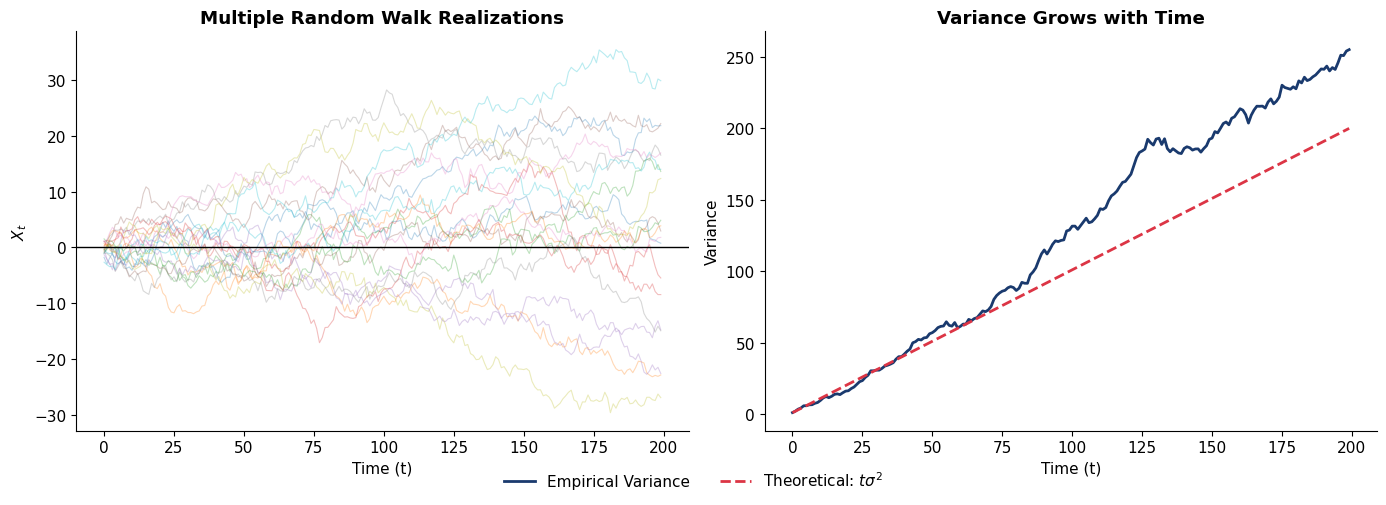

In [23]:
# Demonstrate variance growth in random walk
np.random.seed(123)
n_simulations = 100
n_steps = 200

# Simulate many random walks
random_walks = np.zeros((n_simulations, n_steps))
for i in range(n_simulations):
    random_walks[i, :] = np.cumsum(np.random.randn(n_steps))

# Calculate variance at each time point
variances = np.var(random_walks, axis=0)
theoretical_var = np.arange(1, n_steps + 1)  # Var(X_t) = t * sigma^2 (sigma=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Multiple random walks
for i in range(20):
    axes[0].plot(random_walks[i, :], alpha=0.3, linewidth=0.8)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0].set_title('Multiple Random Walk Realizations', fontweight='bold')
axes[0].set_xlabel('Time (t)')
axes[0].set_ylabel('$X_t$')

# Variance over time
axes[1].plot(variances, color=COLORS['blue'], linewidth=2, label='Empirical Variance')
axes[1].plot(theoretical_var, color=COLORS['red'], linestyle='--', 
             linewidth=2, label='Theoretical: $t\\sigma^2$')
axes[1].set_title('Variance Grows with Time', fontweight='bold')
axes[1].set_xlabel('Time (t)')
axes[1].set_ylabel('Variance')

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [24]:
print("\nRandom Walk is NON-STATIONARY because Var(X_t) = t*sigma^2 depends on t")


Random Walk is NON-STATIONARY because Var(X_t) = t*sigma^2 depends on t


### Random Walk Properties

$X_t = X_{t-1} + \varepsilon_t$ where $\varepsilon_t \sim WN(0, \sigma^2)$

- $E[X_t] = X_0$ (constant)
- $Var(X_t) = t\sigma^2$ (**grows with time!**)
- This violates stationarity!

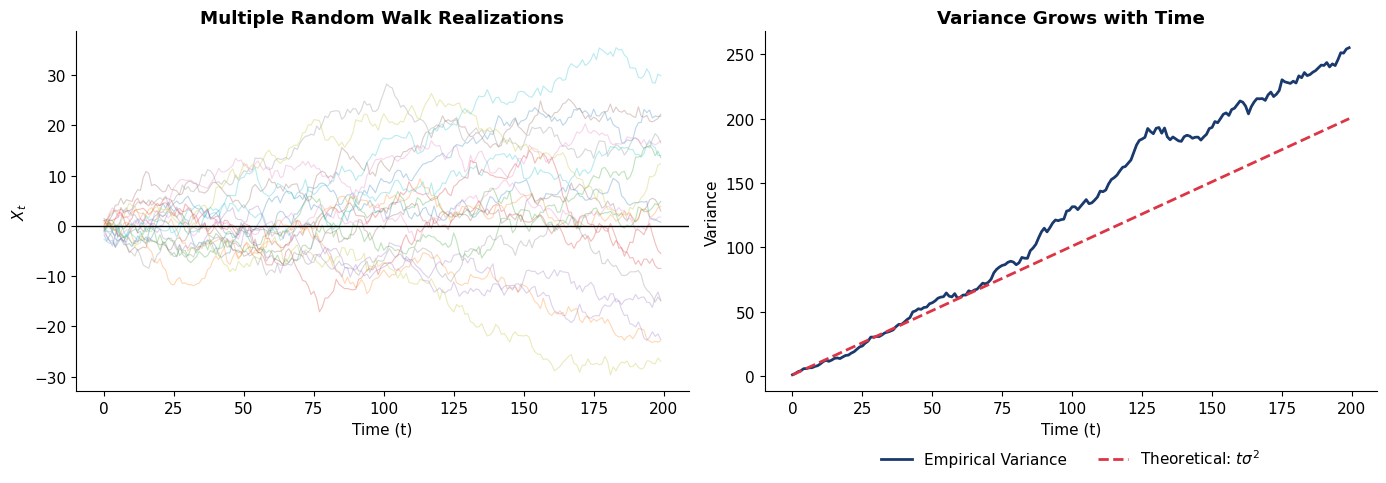


Random Walk is NON-STATIONARY because Var(X_t) = t*σ² depends on t


In [25]:
# Demonstrate variance growth in random walk
np.random.seed(123)
n_simulations = 100
n_steps = 200

# Simulate many random walks
random_walks = np.zeros((n_simulations, n_steps))
for i in range(n_simulations):
    random_walks[i, :] = np.cumsum(np.random.randn(n_steps))

# Calculate variance at each time point
variances = np.var(random_walks, axis=0)
theoretical_var = np.arange(1, n_steps + 1)  # Var(X_t) = t * sigma^2 (sigma=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Multiple random walks
for i in range(20):
    axes[0].plot(random_walks[i, :], alpha=0.3, linewidth=0.8)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0].set_title('Multiple Random Walk Realizations', fontweight='bold')
axes[0].set_xlabel('Time (t)')
axes[0].set_ylabel('$X_t$')

# Variance over time
axes[1].plot(variances, color=COLORS['blue'], linewidth=2, label='Empirical Variance')
axes[1].plot(theoretical_var, color=COLORS['red'], linestyle='--', 
             linewidth=2, label='Theoretical: $t\\sigma^2$')
axes[1].set_title('Variance Grows with Time', fontweight='bold')
axes[1].set_xlabel('Time (t)')
axes[1].set_ylabel('Variance')
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)

plt.tight_layout()
plt.show()

print("\nRandom Walk is NON-STATIONARY because Var(X_t) = t*σ² depends on t")

## 6. Testing for Stationarity

### ADF Test (Augmented Dickey-Fuller)
- $H_0$: Unit root (non-stationary)
- $H_1$: Stationary
- Reject $H_0$ if p-value < 0.05 → **Stationary**

### KPSS Test
- $H_0$: Stationary
- $H_1$: Unit root (non-stationary)
- Reject $H_0$ if p-value < 0.05 → **Non-stationary**

**Use both tests together for robust conclusions!**

In [26]:
def test_stationarity(series, name):
    """Perform ADF and KPSS tests and report results"""
    print(f"\n{'='*50}")
    print(f"Stationarity Tests for: {name}")
    print('='*50)
    
    # ADF Test
    adf_result = adfuller(series, autolag='AIC')
    print(f"\nADF Test:")
    print(f"  Test Statistic: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Critical Values:")
    for key, value in adf_result[4].items():
        print(f"    {key}: {value:.4f}")
    
    adf_conclusion = "STATIONARY" if adf_result[1] < 0.05 else "NON-STATIONARY"
    print(f"  Conclusion: {adf_conclusion} (reject H0: unit root)" if adf_result[1] < 0.05 
          else f"  Conclusion: {adf_conclusion} (fail to reject H0: unit root)")
    
    # KPSS Test
    kpss_result = kpss(series, regression='c', nlags='auto')
    print(f"\nKPSS Test:")
    print(f"  Test Statistic: {kpss_result[0]:.4f}")
    print(f"  p-value: {kpss_result[1]:.4f}")
    print(f"  Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"    {key}: {value:.4f}")
    
    kpss_conclusion = "NON-STATIONARY" if kpss_result[1] < 0.05 else "STATIONARY"
    print(f"  Conclusion: {kpss_conclusion} (reject H0: stationary)" if kpss_result[1] < 0.05 
          else f"  Conclusion: {kpss_conclusion} (fail to reject H0: stationary)")
    
    return adf_result[1], kpss_result[1]

In [27]:
# Test S&P 500 prices
prices = sp500['Close'].dropna()
test_stationarity(prices, 'S&P 500 Prices')


Stationarity Tests for: S&P 500 Prices

ADF Test:
  Test Statistic: -0.3434
  p-value: 0.9191
  Critical Values:
    1%: -3.4356
    5%: -2.8639
    10%: -2.5680
  Conclusion: NON-STATIONARY (fail to reject H0: unit root)

KPSS Test:
  Test Statistic: 4.1351
  p-value: 0.0100
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  Conclusion: NON-STATIONARY (reject H0: stationary)


/var/folders/pk/sxdc5n5x6mb322grbvxz_nm40000gp/T/ipykernel_13264/1998054482.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


(np.float64(0.9191214825483127), np.float64(0.01))

In [28]:
# Calculate returns (percentage changes)
returns = sp500['Close'].pct_change().dropna() * 100

# Test returns for stationarity
test_stationarity(returns, 'S&P 500 Returns')


Stationarity Tests for: S&P 500 Returns

ADF Test:
  Test Statistic: -10.7080
  p-value: 0.0000
  Critical Values:
    1%: -3.4356
    5%: -2.8639
    10%: -2.5680
  Conclusion: STATIONARY (reject H0: unit root)

KPSS Test:
  Test Statistic: 0.0590
  p-value: 0.1000
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  Conclusion: STATIONARY (fail to reject H0: stationary)


/var/folders/pk/sxdc5n5x6mb322grbvxz_nm40000gp/T/ipykernel_13264/1998054482.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


(np.float64(3.388307729791324e-19), np.float64(0.1))

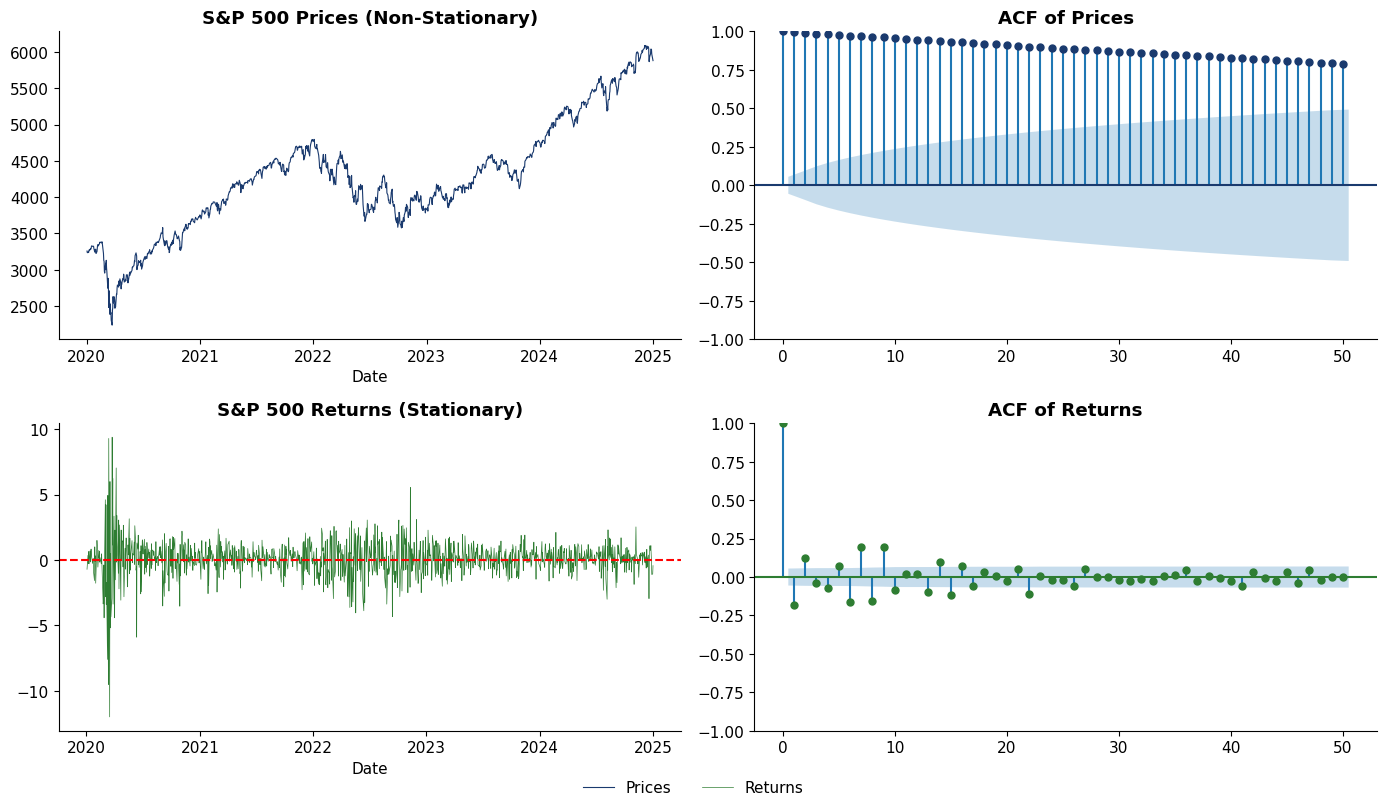

In [29]:
# Visualize the difference
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Prices
axes[0, 0].plot(prices.index, prices, color=COLORS['blue'], linewidth=0.8, label='Prices')
axes[0, 0].set_title('S&P 500 Prices (Non-Stationary)', fontweight='bold')
axes[0, 0].set_xlabel('Date')

# Prices ACF
plot_acf(prices, ax=axes[0, 1], lags=50, color=COLORS['blue'])
axes[0, 1].set_title('ACF of Prices', fontweight='bold')

# Returns
axes[1, 0].plot(returns.index, returns, color=COLORS['green'], linewidth=0.5, label='Returns')
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_title('S&P 500 Returns (Stationary)', fontweight='bold')
axes[1, 0].set_xlabel('Date')

# Returns ACF
plot_acf(returns, ax=axes[1, 1], lags=50, color=COLORS['green'])
axes[1, 1].set_title('ACF of Returns', fontweight='bold')

# Collect handles and labels
handles = [axes[0, 0].get_legend_handles_labels()[0][0], 
           axes[1, 0].get_legend_handles_labels()[0][0]]
labels = ['Prices', 'Returns']
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.1)
plt.tight_layout()
plt.show()

In [30]:
print("\nKey Insight:")
print("- Prices are non-stationary (random walk behavior)")
print("- Returns (differences) are stationary")
print("- This is why we model RETURNS, not prices, in finance!")


Key Insight:
- Prices are non-stationary (random walk behavior)
- Returns (differences) are stationary
- This is why we model RETURNS, not prices, in finance!


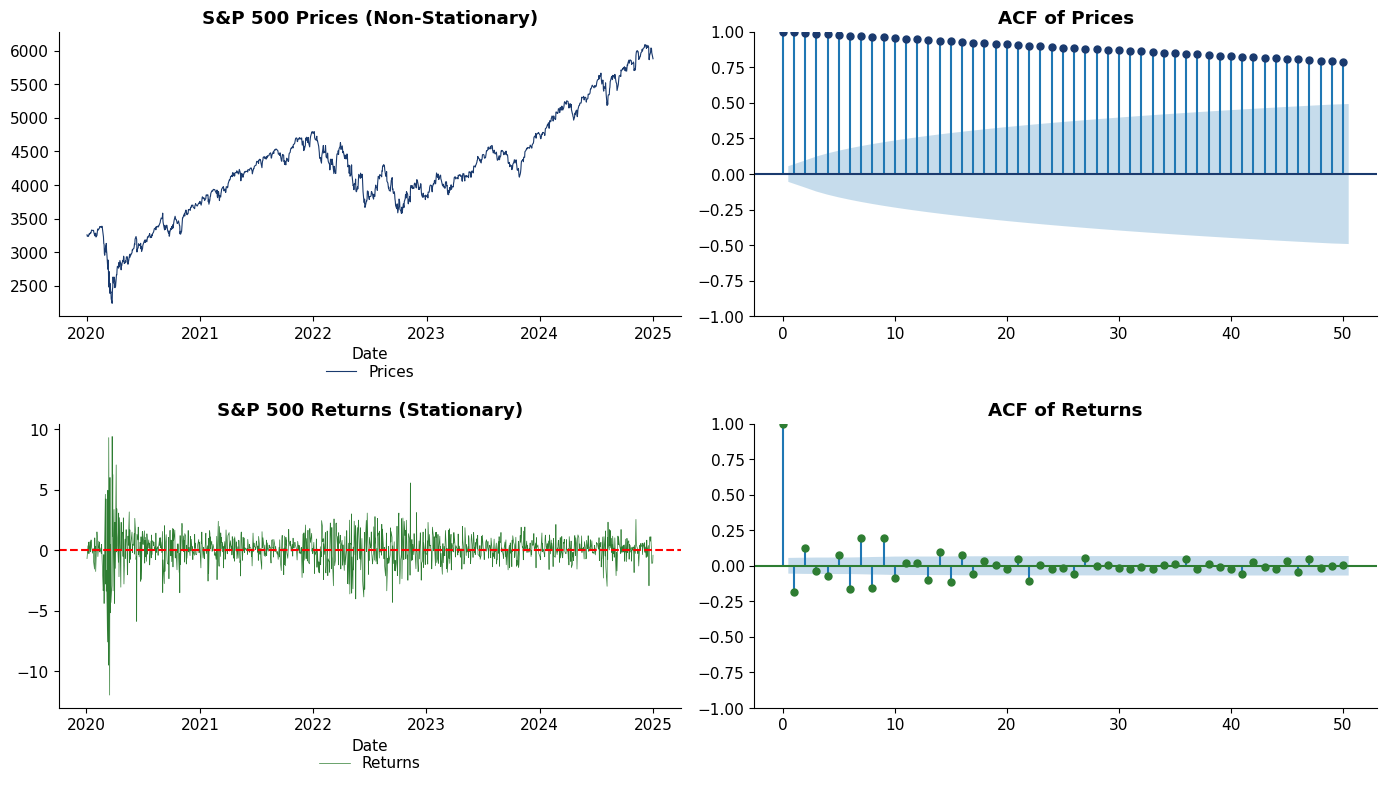


Key Insight:
- Prices are non-stationary (random walk behavior)
- Returns (differences) are stationary
- This is why we model RETURNS, not prices, in finance!


In [31]:
# Visualize the difference
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Prices
axes[0, 0].plot(prices.index, prices, color=COLORS['blue'], linewidth=0.8, label='Prices')
axes[0, 0].set_title('S&P 500 Prices (Non-Stationary)', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=1, frameon=False)

# Prices ACF
plot_acf(prices, ax=axes[0, 1], lags=50, color=COLORS['blue'])
axes[0, 1].set_title('ACF of Prices', fontweight='bold')

# Returns
axes[1, 0].plot(returns.index, returns, color=COLORS['green'], linewidth=0.5, label='Returns')
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_title('S&P 500 Returns (Stationary)', fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=1, frameon=False)

# Returns ACF
plot_acf(returns, ax=axes[1, 1], lags=50, color=COLORS['green'])
axes[1, 1].set_title('ACF of Returns', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("- Prices are non-stationary (random walk behavior)")
print("- Returns (differences) are stationary")
print("- This is why we model RETURNS, not prices, in finance!")

# Simulate AR(1) and MA(1) processes
np.random.seed(42)
n = 500

# AR(1): X_t = 0.7 * X_{t-1} + epsilon_t
phi = 0.7
ar1 = np.zeros(n)
for t in range(1, n):
    ar1[t] = phi * ar1[t-1] + np.random.randn()

# MA(1): X_t = epsilon_t + 0.7 * epsilon_{t-1}
theta = 0.7
epsilon = np.random.randn(n)
ma1 = np.zeros(n)
for t in range(1, n):
    ma1[t] = epsilon[t] + theta * epsilon[t-1]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# AR(1)
axes[0, 0].plot(ar1, color=COLORS['blue'], linewidth=0.8, label='AR(1)')
axes[0, 0].set_title('AR(1) Process: $X_t = 0.7X_{t-1} + \\varepsilon_t$', fontweight='bold')

plot_acf(ar1, ax=axes[0, 1], lags=20, color=COLORS['blue'])
axes[0, 1].set_title('ACF of AR(1) - Decays', fontweight='bold')

plot_pacf(ar1, ax=axes[0, 2], lags=20, color=COLORS['blue'], method='ywm')
axes[0, 2].set_title('PACF of AR(1) - Cuts off at lag 1', fontweight='bold')

# MA(1)
axes[1, 0].plot(ma1, color=COLORS['green'], linewidth=0.8, label='MA(1)')
axes[1, 0].set_title('MA(1) Process: $X_t = \\varepsilon_t + 0.7\\varepsilon_{t-1}$', fontweight='bold')

plot_acf(ma1, ax=axes[1, 1], lags=20, color=COLORS['green'])
axes[1, 1].set_title('ACF of MA(1) - Cuts off at lag 1', fontweight='bold')

plot_pacf(ma1, ax=axes[1, 2], lags=20, color=COLORS['green'], method='ywm')
axes[1, 2].set_title('PACF of MA(1) - Decays', fontweight='bold')

# Collect handles and labels
handles = [axes[0, 0].get_legend_handles_labels()[0][0], 
           axes[1, 0].get_legend_handles_labels()[0][0]]
labels = ['AR(1)', 'MA(1)']
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.1)
plt.tight_layout()
plt.show()

In [32]:
print("\nModel Identification Rules:")
print("-" * 40)
print("| Process | ACF          | PACF         |")
print("-" * 40)
print("| AR(p)   | Decays       | Cuts off @ p |")
print("| MA(q)   | Cuts off @ q | Decays       |")
print("| ARMA    | Decays       | Decays       |")
print("-" * 40)


Model Identification Rules:
----------------------------------------
| Process | ACF          | PACF         |
----------------------------------------
| AR(p)   | Decays       | Cuts off @ p |
| MA(q)   | Cuts off @ q | Decays       |
| ARMA    | Decays       | Decays       |
----------------------------------------


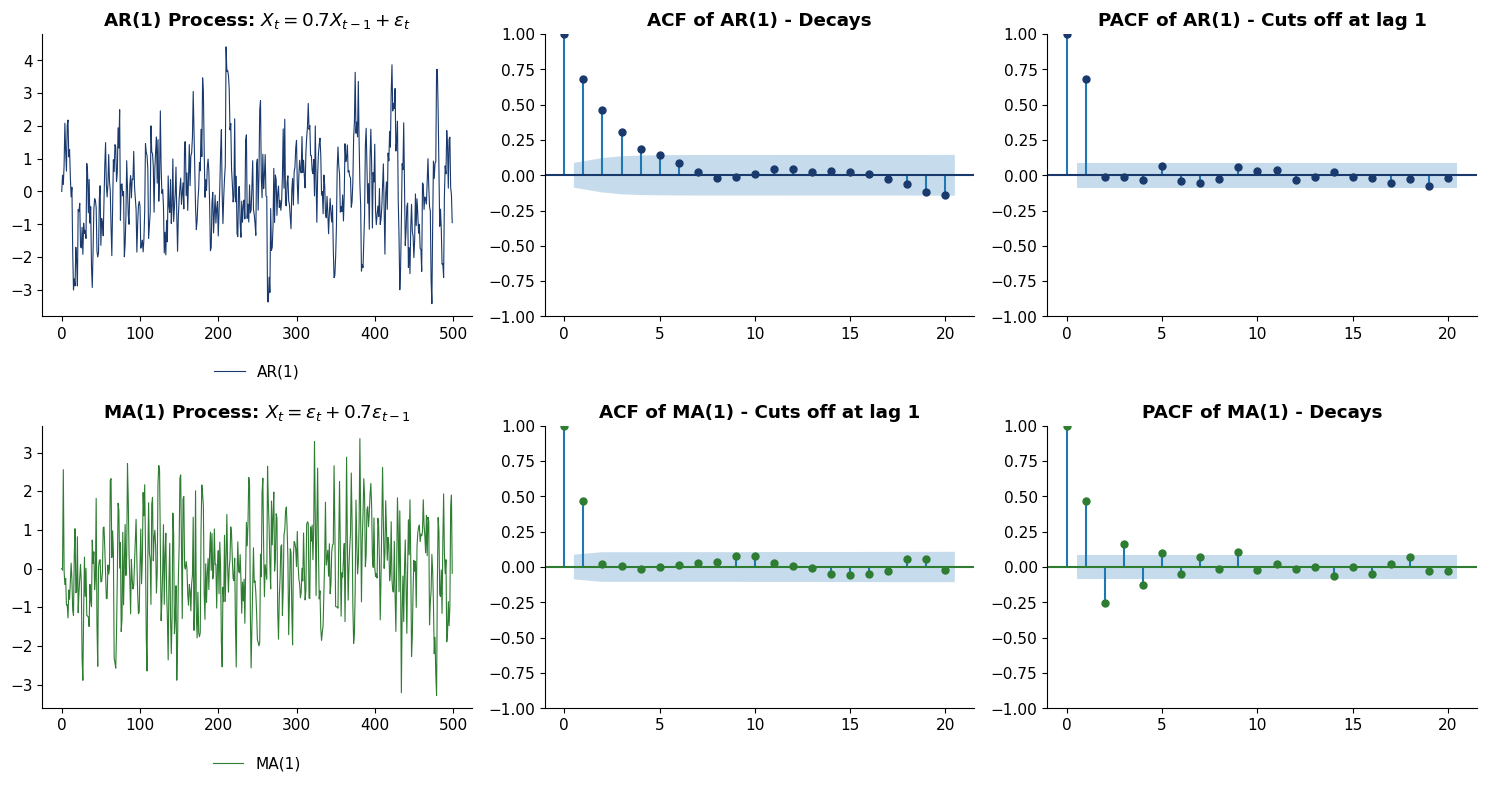


Model Identification Rules:
----------------------------------------
| Process | ACF          | PACF         |
----------------------------------------
| AR(p)   | Decays       | Cuts off @ p |
| MA(q)   | Cuts off @ q | Decays       |
| ARMA    | Decays       | Decays       |
----------------------------------------


In [33]:
# Simulate AR(1) and MA(1) processes
np.random.seed(42)
n = 500

# AR(1): X_t = 0.7 * X_{t-1} + epsilon_t
phi = 0.7
ar1 = np.zeros(n)
for t in range(1, n):
    ar1[t] = phi * ar1[t-1] + np.random.randn()

# MA(1): X_t = epsilon_t + 0.7 * epsilon_{t-1}
theta = 0.7
epsilon = np.random.randn(n)
ma1 = np.zeros(n)
for t in range(1, n):
    ma1[t] = epsilon[t] + theta * epsilon[t-1]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# AR(1)
axes[0, 0].plot(ar1, color=COLORS['blue'], linewidth=0.8, label='AR(1)')
axes[0, 0].set_title('AR(1) Process: $X_t = 0.7X_{t-1} + \\varepsilon_t$', fontweight='bold')
axes[0, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=1, frameon=False)

plot_acf(ar1, ax=axes[0, 1], lags=20, color=COLORS['blue'])
axes[0, 1].set_title('ACF of AR(1) - Decays', fontweight='bold')

plot_pacf(ar1, ax=axes[0, 2], lags=20, color=COLORS['blue'], method='ywm')
axes[0, 2].set_title('PACF of AR(1) - Cuts off at lag 1', fontweight='bold')

# MA(1)
axes[1, 0].plot(ma1, color=COLORS['green'], linewidth=0.8, label='MA(1)')
axes[1, 0].set_title('MA(1) Process: $X_t = \\varepsilon_t + 0.7\\varepsilon_{t-1}$', fontweight='bold')
axes[1, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=1, frameon=False)

plot_acf(ma1, ax=axes[1, 1], lags=20, color=COLORS['green'])
axes[1, 1].set_title('ACF of MA(1) - Cuts off at lag 1', fontweight='bold')

plot_pacf(ma1, ax=axes[1, 2], lags=20, color=COLORS['green'], method='ywm')
axes[1, 2].set_title('PACF of MA(1) - Decays', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nModel Identification Rules:")
print("-" * 40)
print("| Process | ACF          | PACF         |")
print("-" * 40)
print("| AR(p)   | Decays       | Cuts off @ p |")
print("| MA(q)   | Cuts off @ q | Decays       |")
print("| ARMA    | Decays       | Decays       |")
print("-" * 40)

## 8. Financial Data: Stylized Facts

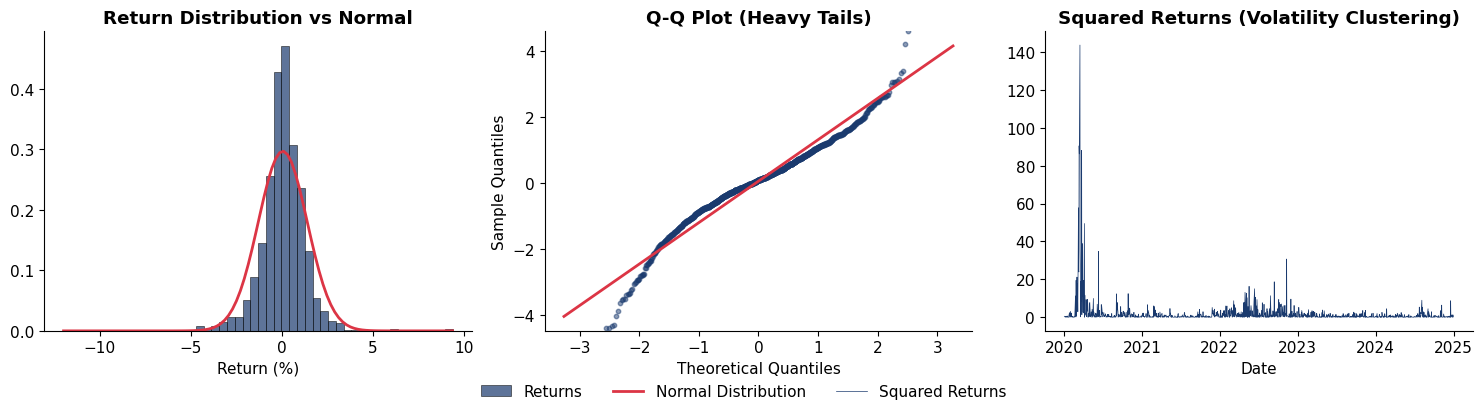

In [34]:
# Analyze return distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram with normal overlay
from scipy.stats import norm
mu, std = returns.mean(), returns.std()
x = np.linspace(returns.min(), returns.max(), 100)

axes[0].hist(returns, bins=50, density=True, color=COLORS['blue'], 
             alpha=0.7, edgecolor='black', linewidth=0.5, label='Returns')
axes[0].plot(x, norm.pdf(x, mu, std), color=COLORS['red'], linewidth=2, 
             label='Normal Distribution')
axes[0].set_title('Return Distribution vs Normal', fontweight='bold')
axes[0].set_xlabel('Return (%)')

# Q-Q plot with appropriate axes
(osm, osr), (slope, intercept, r) = stats.probplot(returns, dist="norm")
axes[1].scatter(osm, osr, color=COLORS['blue'], s=10, alpha=0.5, label='Sample Quantiles')
axes[1].plot(osm, slope*osm + intercept, color=COLORS['red'], linewidth=2, label='Theoretical Line')
axes[1].set_title('Q-Q Plot (Heavy Tails)', fontweight='bold')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')
# Set axis limits based on theoretical quantiles
q_range = abs(osm).max() * 1.1
axes[1].set_xlim(-q_range, q_range)
axes[1].set_ylim(-q_range * slope + intercept - abs(intercept)*0.5, 
                 q_range * slope + intercept + abs(intercept)*0.5)

# Volatility clustering (squared returns)
axes[2].plot(returns.index, returns**2, color=COLORS['blue'], linewidth=0.5, label='Squared Returns')
axes[2].set_title('Squared Returns (Volatility Clustering)', fontweight='bold')
axes[2].set_xlabel('Date')

# Collect handles and labels
handles = [axes[0].get_legend_handles_labels()[0][0], 
           axes[0].get_legend_handles_labels()[0][1],
           axes[2].get_legend_handles_labels()[0][0]]
labels = ['Returns', 'Normal Distribution', 'Squared Returns']
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

In [35]:
# Statistics
from scipy.stats import skew, kurtosis
print("\nStylized Facts of Financial Returns:")
print(f"  Mean: {mu:.4f}%")
print(f"  Std Dev: {std:.4f}%")
print(f"  Skewness: {skew(returns):.4f} (negative = left tail)")
print(f"  Excess Kurtosis: {kurtosis(returns):.4f} (>0 = heavy tails)")
print("\n  -> Returns are NOT normally distributed!")
print("  -> Volatility clusters (large moves follow large moves)")


Stylized Facts of Financial Returns:
  Mean: 0.0561%
  Std Dev: 1.3443%
  Skewness: -0.5130 (negative = left tail)
  Excess Kurtosis: 13.0702 (>0 = heavy tails)

  -> Returns are NOT normally distributed!
  -> Volatility clusters (large moves follow large moves)


## Summary

### Key Takeaways

1. **Time series** = observations indexed by time with temporal dependence
2. **Decomposition**: Additive vs Multiplicative based on seasonal behavior
3. **Exponential Smoothing**: SES (level), Holt (trend), Holt-Winters (seasonal)
4. **Forecast Evaluation**: MAE, RMSE, MAPE; proper train/validation/test splits
5. **Stationarity**: Constant mean, variance, and autocovariance over time
6. **Unit Root Tests**: ADF (H0: unit root) and KPSS (H0: stationary)
7. **ACF/PACF**: Essential tools for identifying dependence structure

### Next Chapter: ARMA Models
- Autoregressive (AR) models
- Moving Average (MA) models  
- Model identification, estimation, and forecasting